In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
import pickle
import matplotlib as mpl
import cmocean
from scipy import stats as spst
import scipy.optimize as scopt

%matplotlib inline

In [33]:

dstart=dt.datetime(2017,1,1)
dend=dt.datetime(2017,7,19)

In [2]:
# conversion factor
r_uE_W=1/0.2174 # (uE/m2/s) / (W/m2)

In [3]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFO_CTD_withModelPAR.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [4]:
session.query(ObsTBL.PAR1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [5]:
session.query(ObsTBL.PAR_1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [6]:
PAR=case([(ObsTBL.PAR!=None, ObsTBL.PAR)], else_=
             case([(ObsTBL.PAR1!=None, ObsTBL.PAR1)], else_=ObsTBL.PAR_1))

In [7]:
SA=case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_= None)))
CT=case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
         case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)], else_=CalcsTBL.Temperature_CT))
ZD=case([(ObsTBL.Depth!=None,ObsTBL.Depth)], else_= CalcsTBL.Z)

In [22]:
qry=session.query(StationTBL.ID.label('StationTBLID'),ObsTBL.ID.label('ObsTBLID'),
                  StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),StationTBL.Lat,StationTBL.Lon,
                ZD.label('Z'),PAR.label('PAR'),SA.label('SA'),CT.label('CT')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0,
                                            StationTBL.StartYear>=dstart.year,
                                            or_(StationTBL.StartYear>dstart.year,StationTBL.StartMonth>=dstart.month),
                                            StationTBL.StartYear<=dend.year,
                                            or_(StationTBL.StartYear<dend.year,StationTBL.StartMonth<=dend.month)))

In [9]:
qry2=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)
minzQ=session.query(StationTBL.ID,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)

In [10]:
df2=pd.DataFrame(qry2.all())


In [11]:
df3=pd.DataFrame(minzQ.all())

In [23]:
df1=pd.DataFrame(qry.all())

In [13]:
len(df2),len(df1),len(df3)

(1735, 319619, 1735)

In [14]:
subminzQ=minzQ.subquery()
subqry=qry.subquery()

In [15]:
sparQ=session.query(subminzQ.c.ID,subminzQ.c.minZ,subqry.c.PAR).select_from(subminzQ).join(subqry,and_(
    ObsTBL.)

SyntaxError: invalid syntax (<ipython-input-15-a29e58daa530>, line 2)

In [24]:
df1=pd.DataFrame(qry.all())
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]


In [25]:
len(df1)

46107

In [26]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

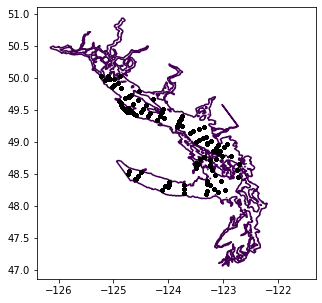

In [27]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(df1['Lon'],df1['Lat'],'k.')
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))

In [28]:
df1.head()

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
0,3834,1078598,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,1.1,12.6,28.322649,6.767869,2017-02-06 23:57:38
1,3834,1078599,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.0,9.6,28.433543,6.910300,2017-02-06 23:57:38
2,3834,1078600,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.8,7.7,28.587849,7.096281,2017-02-06 23:57:38
3,3834,1078601,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.4,3.1,28.700628,7.205176,2017-02-06 23:57:38
4,3834,1078602,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.9,2.8,29.077813,7.656784,2017-02-06 23:57:38


In [29]:
df1.tail()

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
46102,4773,1396766,2017.0,6.0,26.0,21.655278,48.7245,-123.418,86.2,0.0,30.650515,9.677441,2017-06-26 21:39:19
46103,4773,1396767,2017.0,6.0,26.0,21.655278,48.7245,-123.418,87.3,0.0,30.650240,9.678042,2017-06-26 21:39:19
46104,4773,1396768,2017.0,6.0,26.0,21.655278,48.7245,-123.418,88.3,0.0,30.650269,9.678326,2017-06-26 21:39:19
46105,4773,1396769,2017.0,6.0,26.0,21.655278,48.7245,-123.418,89.2,0.0,30.652605,9.677485,2017-06-26 21:39:19
46106,4773,1396770,2017.0,6.0,26.0,21.655278,48.7245,-123.418,90.3,0.0,30.659165,9.674741,2017-06-26 21:39:19


In [34]:
flen=10
namfmt='long'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'PAR':'prod_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'prod_T':1,}
PATH='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/PAR_13bfastSiLR/'
data=et.matchData(df1,filemap,fdict,dstart,dend,namfmt,PATH,flen)

ftype=prod_T, are you sure? (if yes, add to list)
progress: 0.0%
progress: 10.844340338777192%
progress: 21.688680677554384%
progress: 32.533021016331574%
progress: 43.37736135510877%
progress: 54.22170169388596%
progress: 65.06604203266315%
progress: 75.91038237144035%
progress: 86.75472271021754%
progress: 97.59906304899472%


In [ ]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFOCTDwithModel.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [35]:
data.drop(data[data.k<0].index,inplace=True)
data['mod_PAR']=data['mod_PAR']*r_uE_W

In [36]:
pickle.dump(data,open('loadPARCTD13bwithCorr.pkl','wb'))

In [122]:
data=pickle.load(open('loadPARCTD2.pkl','rb'))

In [37]:
data

,StationTBLID,ObsTBLID,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC,j,i,mod_PAR,k
0,3834,1078598,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,1.1,12.6,28.322649,6.767869,2017-02-06 23:57:38,355,208,8.834780e+01,1
1,3834,1078599,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.0,9.6,28.433543,6.910300,2017-02-06 23:57:38,355,208,8.834780e+01,1
2,3834,1078600,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.8,7.7,28.587849,7.096281,2017-02-06 23:57:38,355,208,7.082184e+01,2
3,3834,1078601,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.4,3.1,28.700628,7.205176,2017-02-06 23:57:38,355,208,2.895203e+01,6
4,3834,1078602,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.9,2.8,29.077813,7.656784,2017-02-06 23:57:38,355,208,2.895203e+01,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46102,4260,1296961,2017.0,7.0,5.0,18.022222,48.670333,-123.499833,141.8,0.0,31.394872,9.607116,2017-07-05 18:01:20,357,209,1.354423e-12,28
46103,4260,1296962,2017.0,7.0,5.0,18.022222,48.670333,-123.499833,142.7,0.0,31.395799,9.607303,2017-07-05 18:01:20,357,209,1.354423e-12,28
46104,4260,1296963,2017.0,7.0,5.0,18.022222,48.670333,-123.499833,143.5,0.0,31.397828,9.608385,2017-07-05 18:01:20,357,209,1.354423e-12,28
46105,4260,1296964,2017.0,7.0,5.0,18.022222,48.670333,-123.499833,145.0,0.0,31.402589,9.610045,2017-07-05 18:01:20,357,209,1.354423e-12,28


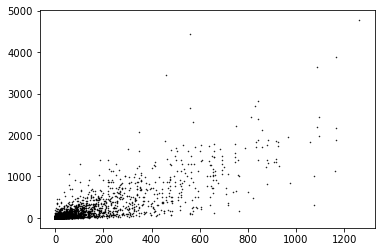

In [38]:
plt.plot(data['mod_PAR'],data['PAR'],'k.',ms=1)

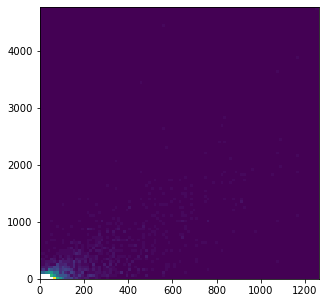

In [39]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
xx=data.loc[ii,['mod_PAR']].values
yy=data.loc[ii,['PAR']].values
ax.hist2d(xx[:,0],yy[:,0],bins=100,cmin=0,cmax=50);

Text(0.5, 1.0, 'PAR Direct Comparison: PAR13b')

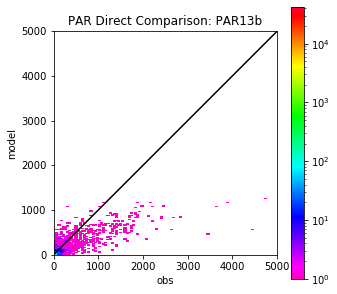

In [72]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(xx[:,0],yy[:,0],bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
ax.set_aspect(1)
ax.plot((0,5000),(0,5000),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison: PAR13b')

Text(0.5, 1.0, 'log10 PAR Direct Comparison: PAR13b')

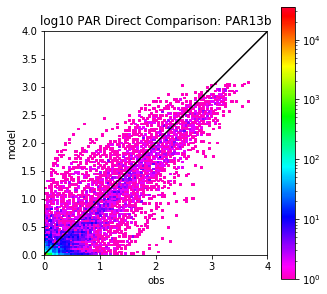

In [73]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('log10 PAR Direct Comparison: PAR13b')

In [44]:
data.keys()

Index(['StationTBLID', 'ObsTBLID', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR', 'k'],
      dtype='object')

In [45]:
stas=data.groupby(by=['Year','Month','Day','Lat','Lon'])

In [46]:
stas

In [47]:
with nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
    deptht=ftemp.variables['deptht'][:]

In [48]:
deptht[5]

5.5001507

In [49]:
data['mod_Z']=[deptht[ii] for ii in data['k']]

Text(0, 0.5, 'Model')

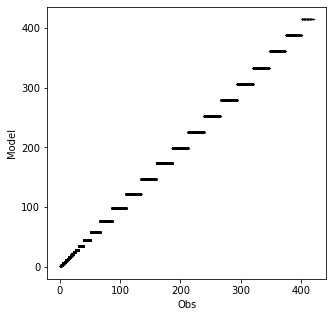

In [50]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(data['Z'],data['mod_Z'],'k.',ms=1)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 10m: HC201812')

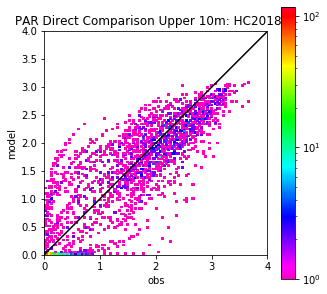

In [51]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 10m: HC201812')

Text(0.5, 1.0, 'PAR Bias vs depth: HC201812')

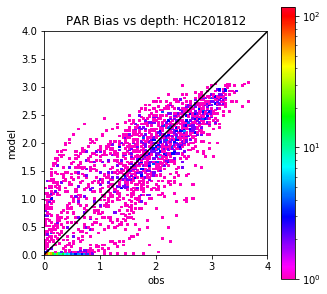

In [52]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Bias vs depth: HC201812')

Text(0.5, 1.0, 'hist: model z - obs z')

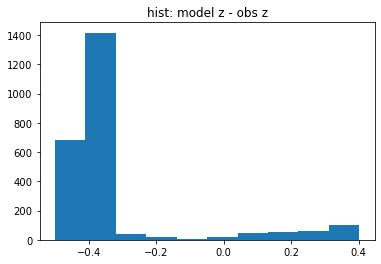

In [53]:
plt.hist(yz-xz)
plt.title('hist: model z - obs z')

Text(0, 0.5, 'log10(model PAR +1)-log10(obs PAR +1)')

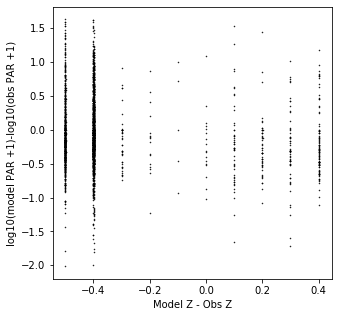

In [54]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(yz-xz,np.log10(yy[:,0]+1)-np.log10(xx[:,0]+1),'k.',ms=1)
ax.set_xlabel('Model Z - Obs Z')
ax.set_ylabel('log10(model PAR +1)-log10(obs PAR +1)')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 2m: PAR13b')

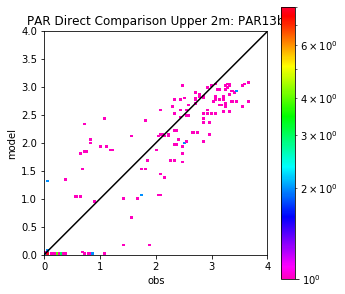

In [74]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<2
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 2m: PAR13b')

In [56]:
data.keys()

Index(['StationTBLID', 'ObsTBLID', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR', 'k',
       'mod_Z'],
      dtype='object')

In [57]:
temp=data.loc[(data['PAR']>0)&(data['mod_PAR']==0)&(data['Z']<3),['dtUTC','Lat','Lon','Z','mod_Z','Hour']]

In [58]:
temp

,dtUTC,Lat,Lon,Z,mod_Z,Hour
207,2017-02-19 07:07:56,48.500000,-124.735667,1.3,1.500003,7.132222
208,2017-02-19 07:07:56,48.500000,-124.735667,2.0,1.500003,7.132222
454,2017-02-19 11:30:59,48.298500,-124.000833,1.1,1.500003,11.516389
455,2017-02-19 11:30:59,48.298500,-124.000833,1.9,1.500003,11.516389
1950,2017-02-20 04:03:48,49.250833,-123.749000,2.0,1.500003,4.063333
2345,2017-02-20 06:16:06,49.318667,-123.800167,1.5,1.500003,6.268333
2346,2017-02-20 06:16:06,49.318667,-123.800167,1.9,1.500003,6.268333
2686,2017-02-20 08:29:48,49.402000,-124.155167,1.5,1.500003,8.496667
2687,2017-02-20 08:29:48,49.402000,-124.155167,1.9,1.500003,8.496667
2961,2017-02-20 10:59:57,49.466500,-124.499500,1.4,1.500003,10.999167


/home/eolson/anaconda3/envs/py38_ct/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


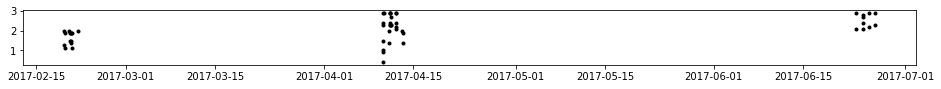

In [59]:
fig,ax=plt.subplots(1,1,figsize=(16,1))
ax.plot(temp['dtUTC'],temp['Z'],'k.')

(array([ 1.,  4.,  9., 13., 10.,  4.,  1.,  6.,  1.,  2.]),
 array([ 4.06333333,  5.03927778,  6.01522222,  6.99116667,  7.96711111,
         8.94305556,  9.919     , 10.89494444, 11.87088889, 12.84683333,
        13.82277778]),
 <a list of 10 Patch objects>)

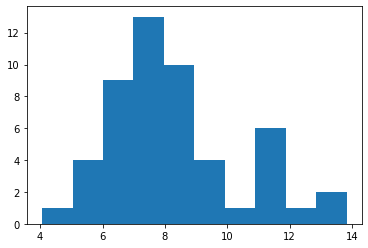

In [60]:
plt.hist(temp['Hour'])

In [61]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

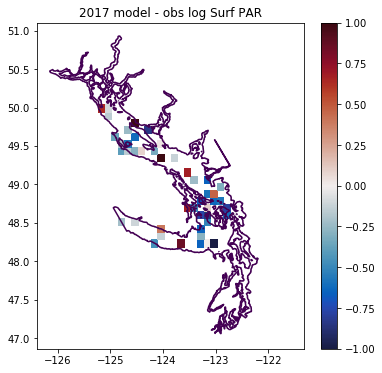

In [65]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&~np.isnan(data['mod_PAR'])&(data['Z']<2)]
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.set_title('2017 model - obs log Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           np.log10(dyr['mod_PAR']+1)-np.log10(dyr['PAR']+1), 
            statistic='mean', bins=20)
m=ax.pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1,vmax=1,shading='flat')
plt.colorbar(m,ax=ax)

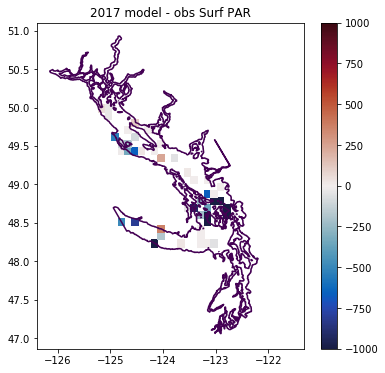

In [75]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['PAR'])&~np.isnan(data['mod_PAR'])&(data['Z']<2)]
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.set_title('2017 model - obs Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax.pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax)

Where model or obs PAR>100 muE/m2/s


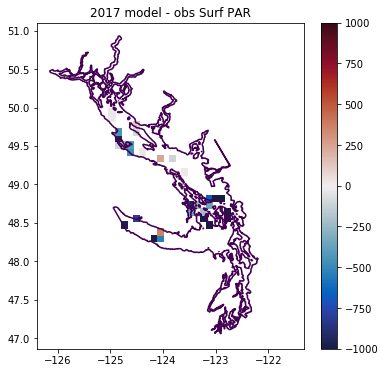

In [68]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
print('Where model or obs PAR>100 muE/m2/s')
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<2)]
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.set_title('2017 model - obs Surf PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax.pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax)

Where model or obs PAR>100 muE/m2/s


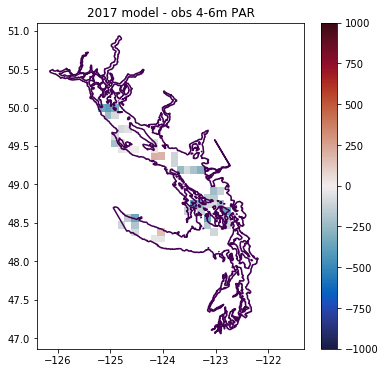

In [69]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
print('Where model or obs PAR>100 muE/m2/s')
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&((data['PAR']>=100)|(data['mod_PAR']>=100))&(data['Z']<6)&(data['Z']>4)]
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.set_title('2017 model - obs 4-6m PAR')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_PAR']-dyr['PAR'], 
            statistic='mean', bins=20)
m=ax.pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-1000,vmax=1000,shading='flat')
plt.colorbar(m,ax=ax)